In [4]:
import numpy as np
import pandas as pd
import rdkit.Chem as Chem
import rdkit.Chem.AllChem as AllChem
from sklearn.ensemble import RandomForestClassifier
import sklearn.metrics as metrics
from rdkit.Chem import Descriptors, Lipinski
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, log_loss
import matplotlib.pyplot as plt
import seaborn as sns



In [5]:
# Load data
file_path = '../data/cmpd.csv'
try:
    cmpd_df = pd.read_csv(file_path)
    print("Data loaded successfully!")
except FileNotFoundError:
    print(f"File not found at {file_path}")
    raise

cmpd_df.head()

Data loaded successfully!


,inchikey,smiles,group,activity
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active


In [6]:
cmpd_df.info()
# check dupilicates
num_duplicates = cmpd_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5530 entries, 0 to 5529
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   inchikey  5530 non-null   object
 1   smiles    5530 non-null   object
 2   group     5530 non-null   object
 3   activity  5530 non-null   object
dtypes: object(4)
memory usage: 172.9+ KB
Number of duplicate rows: 12


In [7]:
# Remove duplicate rows
cmpd_df = cmpd_df.drop_duplicates()



In [8]:
num_duplicates = cmpd_df.duplicated().sum()
print(f"Number of duplicate rows: {num_duplicates}")

Number of duplicate rows: 0


In [9]:
# check missing values
missing_values = cmpd_df.isnull().sum()
missing_percent = (missing_values/len(cmpd_df)) * 100
print("Missing Values (absolute counts):")
print (missing_values)
print("\nMissing Values (percentages):")
print(missing_percent)

Missing Values (absolute counts):
inchikey    0
smiles      0
group       0
activity    0
dtype: int64

Missing Values (percentages):
inchikey    0.0
smiles      0.0
group       0.0
activity    0.0
dtype: float64


Unique activity labels: ['active' 'inactive' 'unknown' 'intermediate']
Activitiy Counts:
activity
active          2692
inactive        1886
unknown          599
intermediate     341
Name: count, dtype: int64

Activity Percentages:
activity
active          48.785792
inactive        34.179050
unknown         10.855382
intermediate     6.179775
Name: count, dtype: float64


Text(0, 0.5, 'Count')

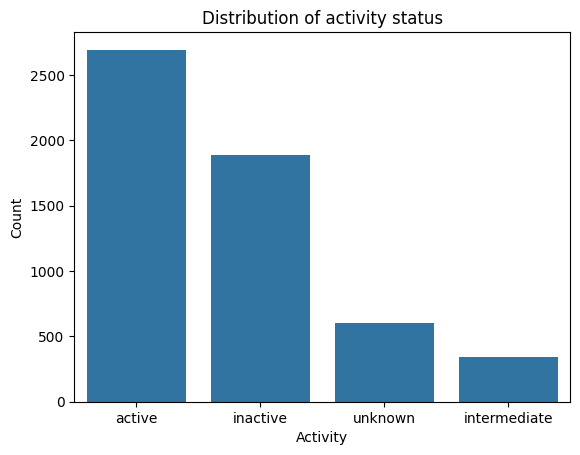

In [10]:
# Analyse activit labels
label_activity = cmpd_df['activity'].unique()
print (f"Unique activity labels: {label_activity}")

# Occurence of each label
activity_counts = cmpd_df['activity'].value_counts()
activity_percent = (activity_counts / len(cmpd_df)) * 100
print ("Activitiy Counts:")
print(activity_counts)
print("\nActivity Percentages:")
print(activity_percent)

sns.countplot(x = 'activity', data=cmpd_df, order=activity_counts.index)
plt.title("Distribution of activity status")
plt.xlabel("Activity")
plt.ylabel('Count')

In [11]:
# Filter dataset to focus on  'active' and 'inactive' compounds
cmpd_df = cmpd_df[cmpd_df['activity'].isin(['active', 'inactive'])]
print("Filtered activity status counts")
print(cmpd_df['activity'].value_counts())


Filtered activity status counts
activity
active      2692
inactive    1886
Name: count, dtype: int64


In [12]:
from tqdm import tqdm
# Convert SMILES to RDKit molecule objects
tqdm.pandas()
cmpd_df['mol'] = cmpd_df['smiles'].progress_apply(lambda x: Chem.MolFromSmiles(x) if pd.notnull(x) else None)

#drop invalid molecules
cmpd_df = cmpd_df[cmpd_df['mol'].notnull()]

cmpd_df.head()

100%|██████████| 4578/4578 [00:01<00:00, 3539.57it/s]


,inchikey,smiles,group,activity,mol
0,FNHKPVJBJVTLMP-UHFFFAOYSA-N,CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...,train,active,<rdkit.Chem.rdchem.Mol object at 0x000002CCB04...
1,CUDVHEFYRIWYQD-UHFFFAOYSA-N,CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...,train,active,<rdkit.Chem.rdchem.Mol object at 0x000002CCB04...
2,TTZSNFLLYPYKIL-UHFFFAOYSA-N,Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...,test,active,<rdkit.Chem.rdchem.Mol object at 0x000002CCB04...
3,UOVCGJXDGOGOCZ-UHFFFAOYSA-N,COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2,train,active,<rdkit.Chem.rdchem.Mol object at 0x000002CCB04...
4,CUIHSIWYWATEQL-UHFFFAOYSA-N,Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...,test,active,<rdkit.Chem.rdchem.Mol object at 0x000002CCB04...


In [14]:
"""
Calculating important molecular descriptors for each compound
From literature review found out that Christopher Lipinski, a scientist at Pfizer proposed a set of rule-of thumb called Lipinski descriptors
for evaluating the druglikeness of compounds, we have used the rule to create features for the model.
The Lipinski's Rule states:
      - Molecular weight < 500 Dalton
      - Octanol-water partition coefficient (LogP) < 5
      - Hydrogen bond donors < 5
      - Hydrogen bond acceptors < 10

"""
# calcluate lipinski descriptors for each molecule
def lipinski_calculation(mol):
    return {
        "MolecularWeight": Descriptors.MolWt(mol),  
        "LogP": Descriptors.MolLogP(mol),           
        "NumHDonors": Descriptors.NumHDonors(mol),  
        "NumHAcceptors": Descriptors.NumHAcceptors(mol), 
        "TPSA": Descriptors.TPSA(mol),              
        "NumRotatableBonds": Descriptors.NumRotatableBonds(mol),  
    }

lipinski_features = cmpd_df['mol'].progress_apply(lipinski_calculation)

# creata a DataFrame
lipinski_df = pd.DataFrame(list(lipinski_features))
lipinski_df.head()

100%|██████████| 4578/4578 [00:01<00:00, 4493.82it/s]


,MolecularWeight,LogP,NumHDonors,NumHAcceptors,TPSA,NumRotatableBonds
0,482.821,5.68880,3,4,92.35,5
1,443.503,4.41860,2,6,95.70,7
2,480.594,3.78322,3,7,112.24,10
3,356.788,4.74532,2,4,62.30,2
4,437.529,3.13904,2,8,119.03,5


In [15]:
# Generate Morgan fingerprints for each molecule
# These fingerprints represent molecular structure and are useful for distinguishing compounds
def get_morgan_fingerprint(mol, radius=2, n_bits=1024):
    """
    Generate Morgan fingerprints with specified radius and bit size.
    """
    morgan_fp = AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=n_bits)
    arr = np.zeros((1,))
    AllChem.DataStructs.ConvertToNumpyArray(morgan_fp, arr)
    return arr

cmpd_df['fingerprint'] = cmpd_df['mol'].progress_apply(get_morgan_fingerprint)

# create a  DataFrame
morgan_feature = np.array(cmpd_df["fingerprint"].to_list())
morgan_df = pd.DataFrame(morgan_feature, columns=[f"FP_{i}" for i in range(morgan_feature.shape[1])])

morgan_df.head()

100%|██████████| 4578/4578 [00:00<00:00, 8236.16it/s]


,FP_0,FP_1,FP_2,FP_3,FP_4,FP_5,FP_6,FP_7,FP_8,FP_9,...,FP_1014,FP_1015,FP_1016,FP_1017,FP_1018,FP_1019,FP_1020,FP_1021,FP_1022,FP_1023
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# Data exploration

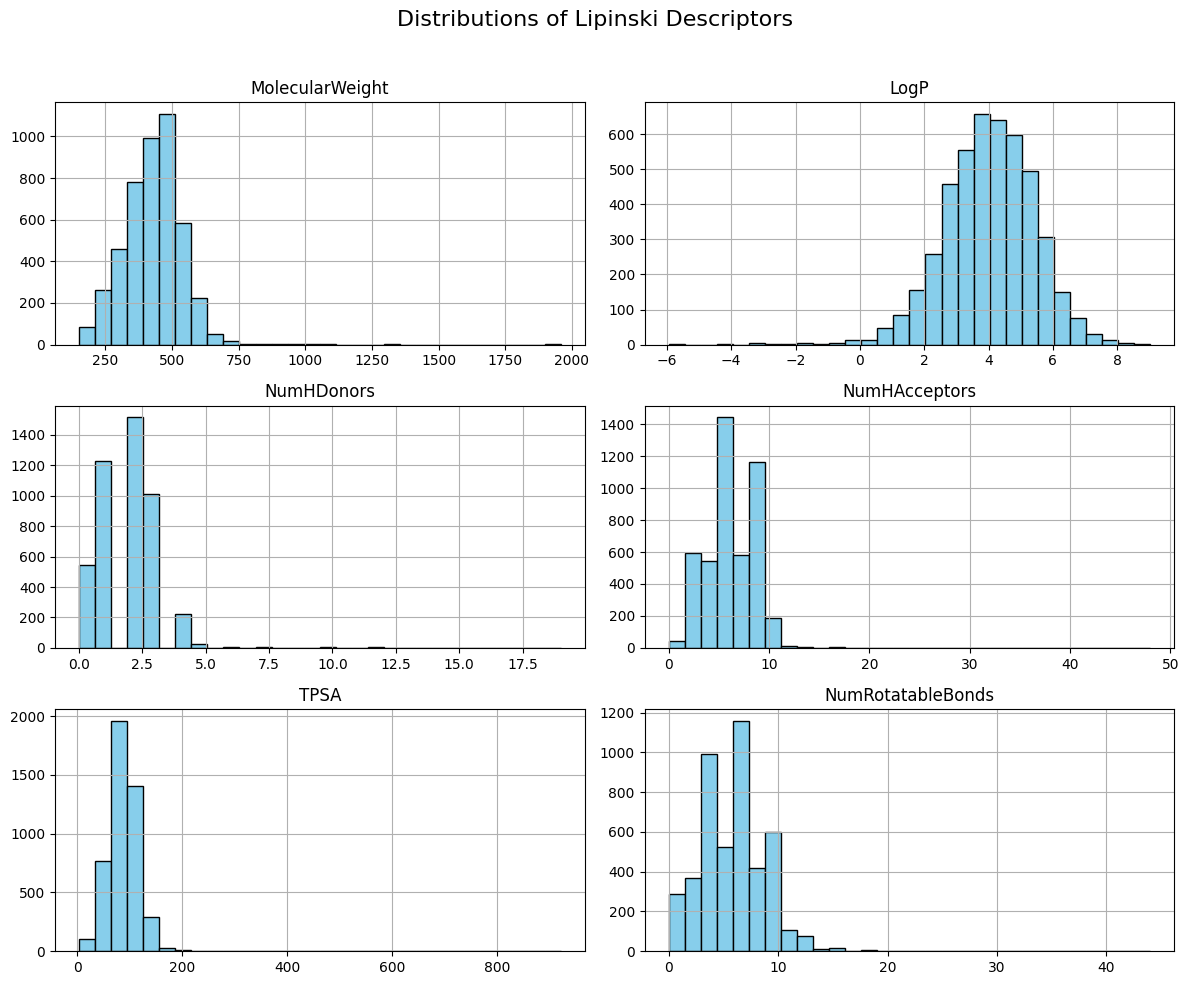

In [17]:
# let see the  distributions for Lipinski descriptors for  data analysis
lipinski_df.hist(figsize=(12, 10), bins=30, color='skyblue', edgecolor='black')
plt.suptitle("Distributions of Lipinski Descriptors", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


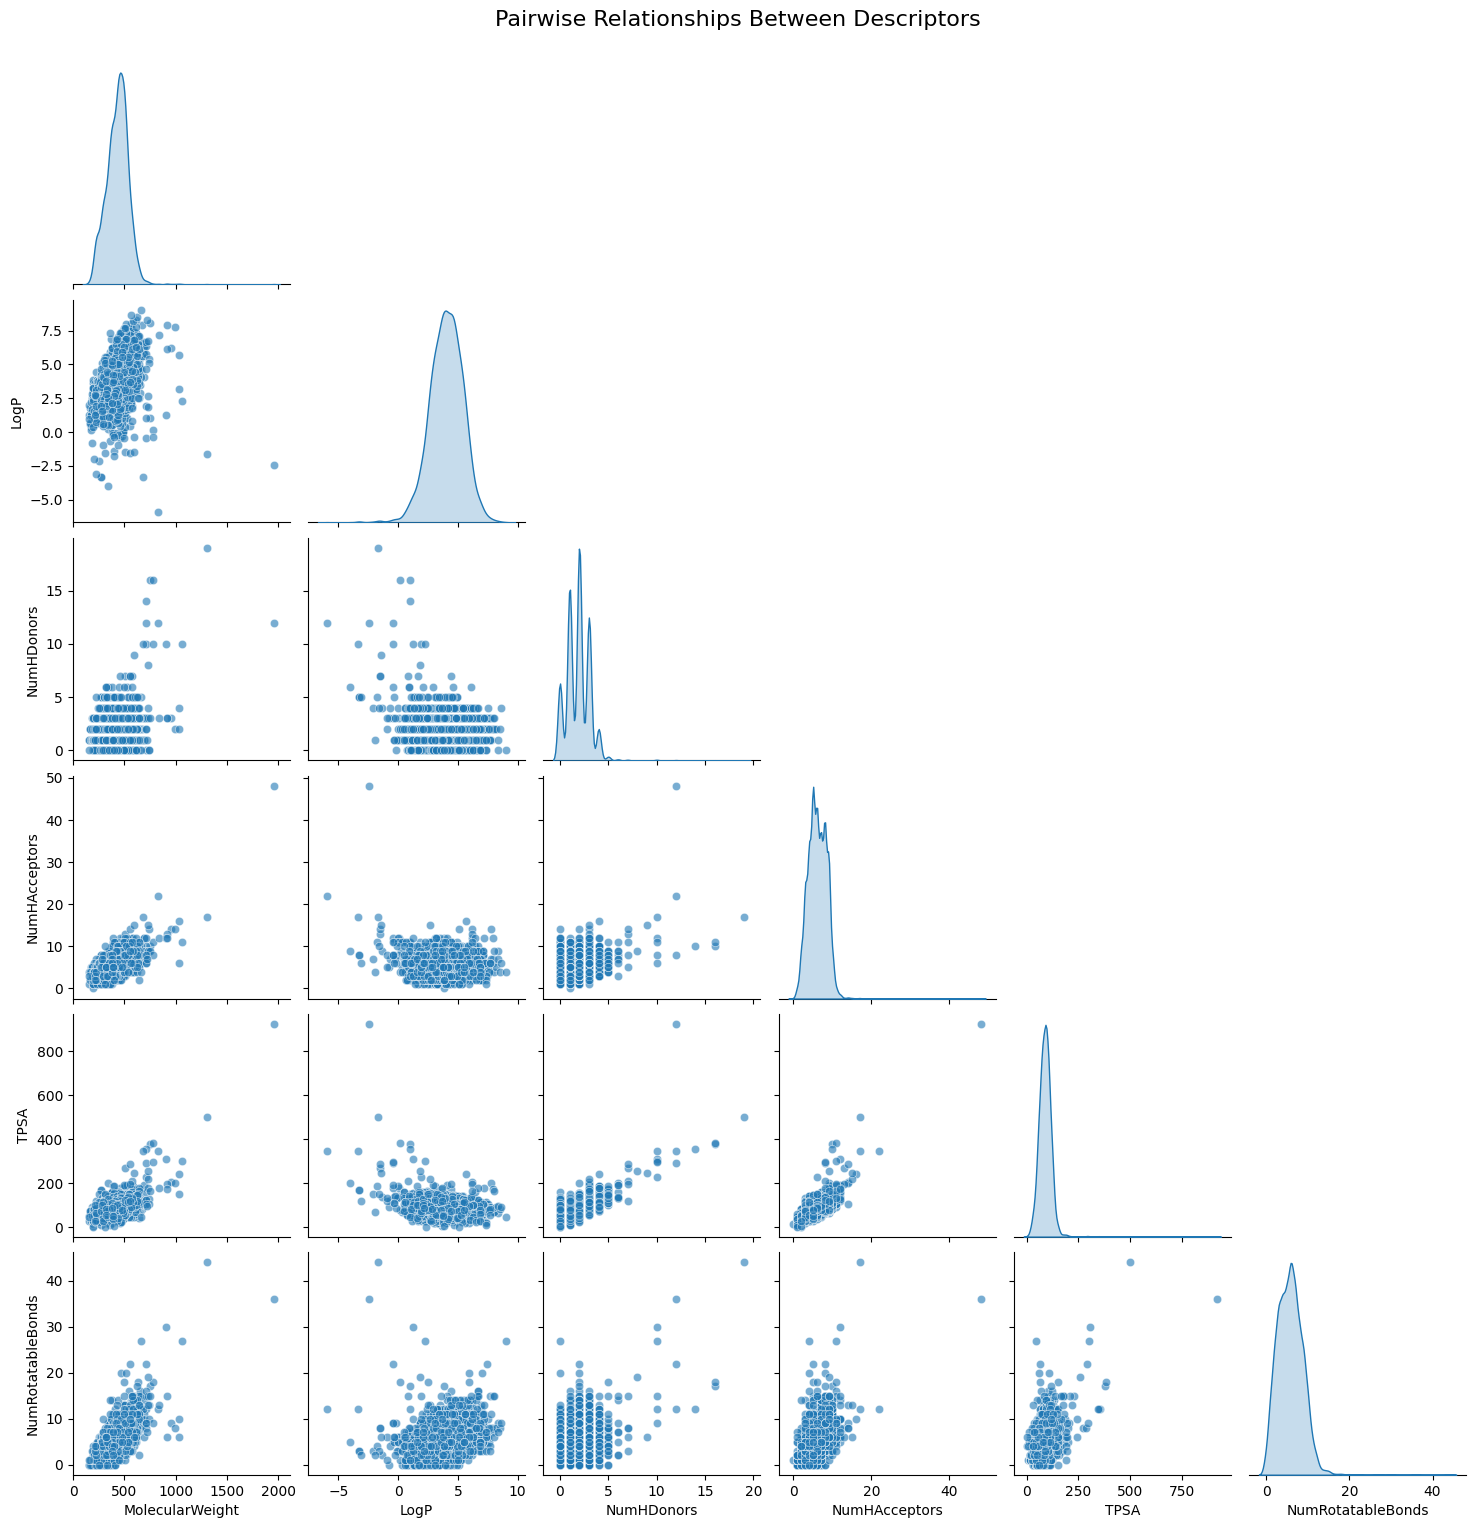

In [19]:
# pairwise relationships between Lipinski descriptors
sns.pairplot(lipinski_df, diag_kind="kde", plot_kws={"alpha": 0.6}, corner=True)
plt.suptitle("Pairwise Relationships Between Descriptors", y=1.02, fontsize=16)
plt.show()


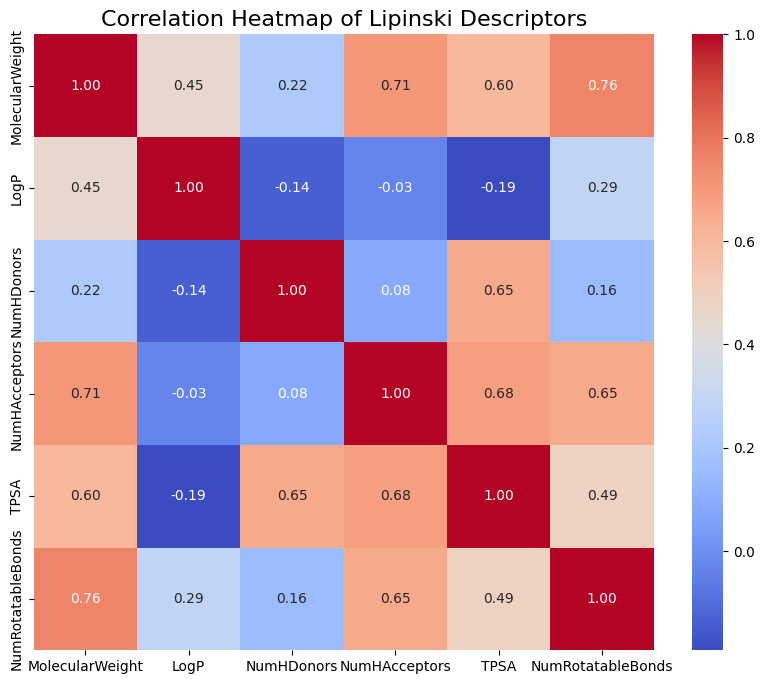

In [20]:
# Correlation heatmap for Lipinski descriptors
plt.figure(figsize=(10, 8))
sns.heatmap(lipinski_df.corr(), annot=True, fmt='.2f', cmap='coolwarm', cbar=True)
plt.title("Correlation Heatmap of Lipinski Descriptors", fontsize=16)
plt.show()


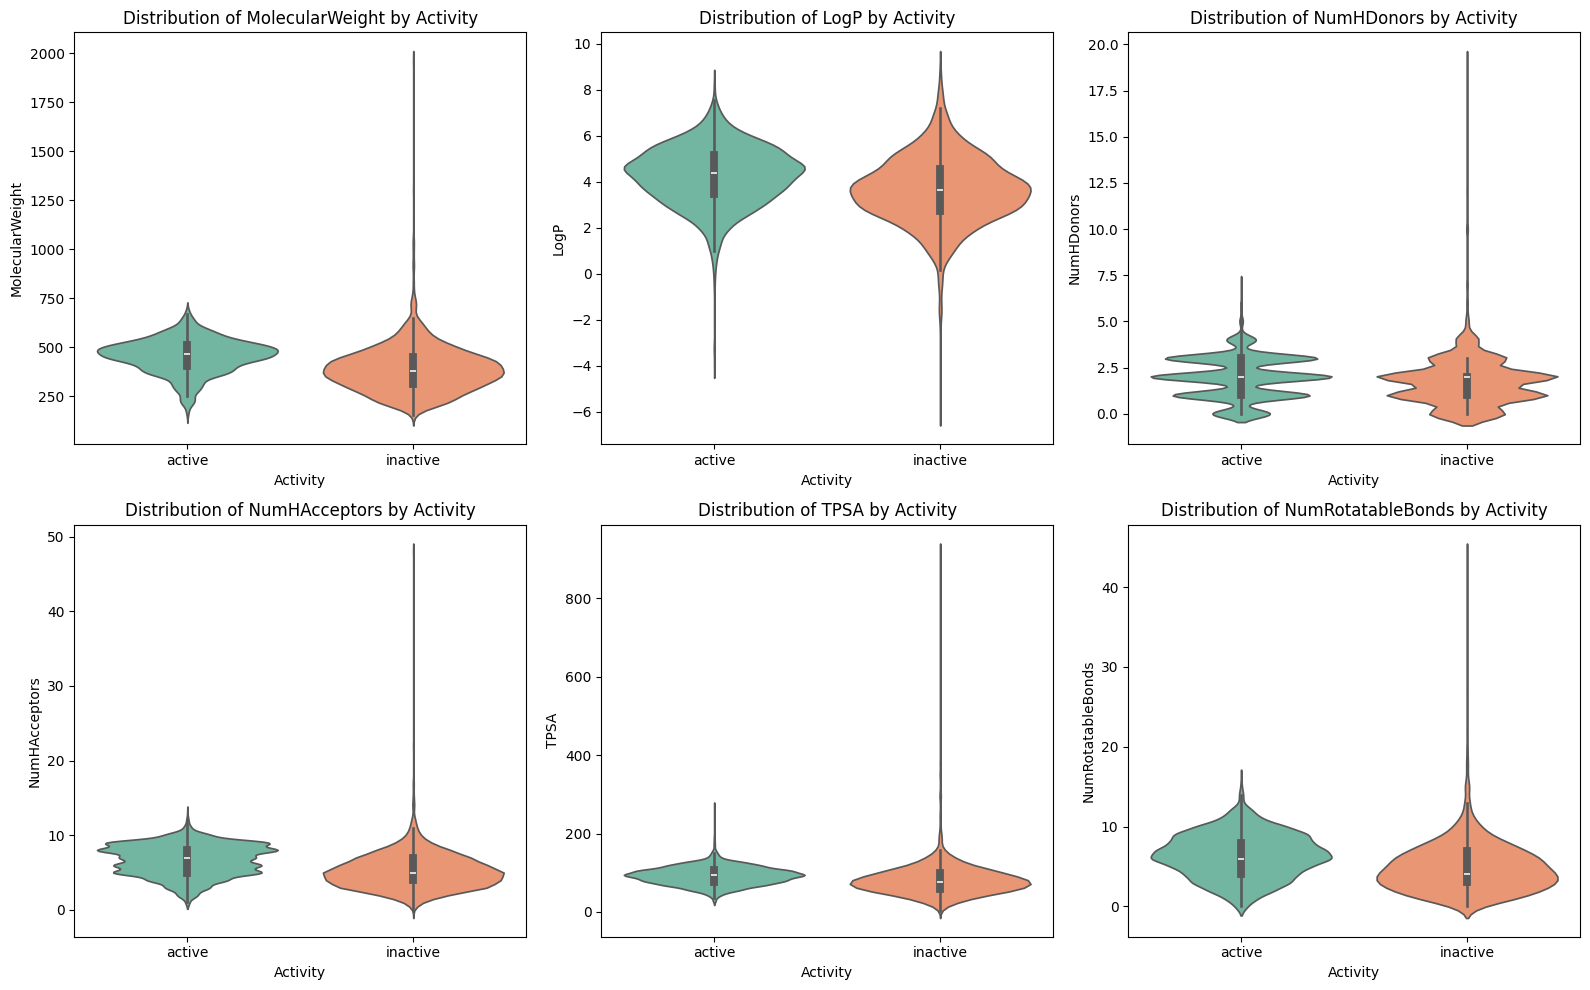

In [21]:

descriptor_activity_df = pd.concat([lipinski_df, cmpd_df['activity'].reset_index(drop=True)], axis=1)

# violin plots for each descriptor to analyse the distribution of the descriptors
plt.figure(figsize=(16, 10))
for i, col in enumerate(lipinski_df.columns):
    plt.subplot(2, 3, i + 1)
    sns.violinplot(x="activity", y=col, data=descriptor_activity_df, hue="activity", palette="Set2", legend=False)
    plt.title(f"Distribution of {col} by Activity")
    plt.xlabel("Activity")
    plt.ylabel(col)
plt.tight_layout()
plt.show()


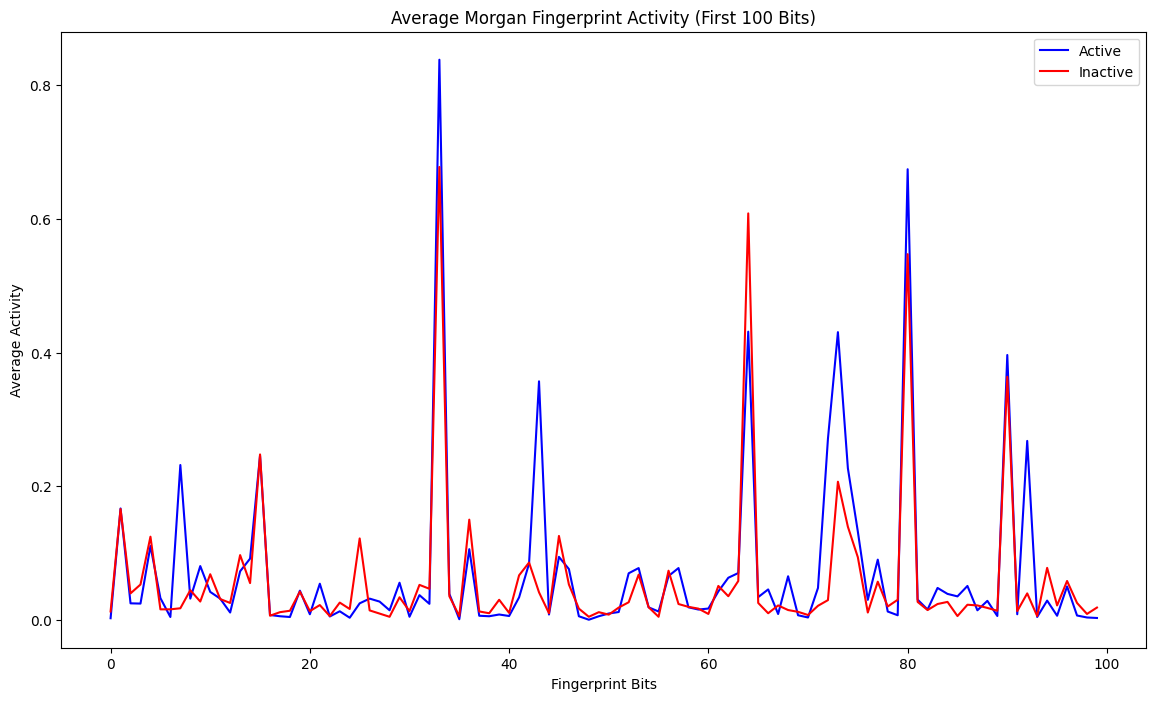

In [22]:
# let us analyse fingerprints
morgan_df = morgan_df.reset_index(drop=True)

cmpd_activity = cmpd_df['activity'].reset_index(drop=True)

# Calculate the average fingerprints for active and inactive compounds
active_fp = morgan_df[cmpd_activity == 'active'].mean()
inactive_fp = morgan_df[cmpd_activity == 'inactive'].mean()

plt.figure(figsize=(14, 8))
plt.plot(active_fp.values[:100], label='Active', color='blue')
plt.plot(inactive_fp.values[:100], label='Inactive', color='red')
plt.title("Average Morgan Fingerprint Activity (First 100 Bits)")
plt.xlabel("Fingerprint Bits")
plt.ylabel("Average Activity")
plt.legend()
plt.show()



Fingerprint Sparsity: 94.69% zeros


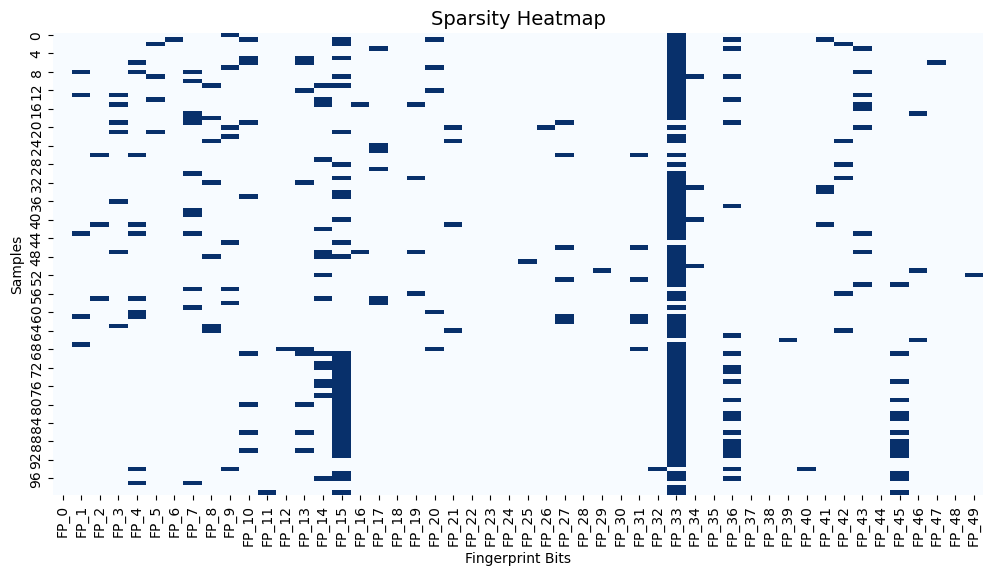

In [23]:
# let us check sparsity of the fingerprints for further data analysis
sparsity = morgan_df.sum().sum() / (morgan_df.shape[0] * morgan_df.shape[1])
print(f"Fingerprint Sparsity: {1 - sparsity:.2%} zeros")

# Heatmap for sparsity (top 50 bits and first 100 compounds)
plt.figure(figsize=(12, 6))
sns.heatmap(morgan_df.iloc[:100, :50], cmap="Blues", cbar=False)
plt.title("Sparsity Heatmap", fontsize=14)
plt.xlabel("Fingerprint Bits")
plt.ylabel("Samples")
plt.show()


In [25]:
# from the sparsity heat map let us check bits with most actives, this helps us to filter bits that might be unecessary for the model training
# exmaple bits > 95 % ( we will filter so that we remain with bits that will provide us meaning full imformation
bit_frequency = morgan_df.mean()
print("Most active bits:")
print(bit_frequency.sort_values(ascending=False).head(10))

Most active bits:
FP_356    0.998689
FP_849    0.996287
FP_726    0.918960
FP_378    0.861293
FP_875    0.818043
FP_33     0.771953
FP_650    0.683923
FP_807    0.654871
FP_428    0.633683
FP_935    0.633464
dtype: float64


In [ ]:
# Encode the 'activity' column to binary labels
y = cmpd_df['activity'].map({'active': 1, 'inactive': 0}).to_numpy()
print("Target labels (y):", y[:10])  

Target labels (y): [1 1 1 1 1 1 1 1 1 1]


In [27]:
#  high-frequency bits
high_frequency_bits = bit_frequency[bit_frequency > 0.95].index

# Drop these bits
morgan_df_filtered = morgan_df.drop(columns=high_frequency_bits)

print(f"Original shape: {morgan_df.shape}")
print(f"Filtered shape: {morgan_df_filtered.shape}")

Original shape: (4578, 1024)
Filtered shape: (4578, 1022)


In [28]:
# Concatenate all data
features_df = pd.concat([cmpd_df.reset_index(drop=True), lipinski_df.reset_index(drop=True), morgan_df_filtered.reset_index(drop=True)], axis=1)
print("all data matrix:")
print(features_df.head())
print(f"Shape of all data: {features_df.shape}")

all data matrix:
                      inchikey  \
0  FNHKPVJBJVTLMP-UHFFFAOYSA-N   
1  CUDVHEFYRIWYQD-UHFFFAOYSA-N   
2  TTZSNFLLYPYKIL-UHFFFAOYSA-N   
3  UOVCGJXDGOGOCZ-UHFFFAOYSA-N   
4  CUIHSIWYWATEQL-UHFFFAOYSA-N   

                                              smiles  group activity  \
0  CNC(=O)c1cc(Oc2ccc(NC(=O)Nc3ccc(Cl)c(C(F)(F)F)...  train   active   
1  CNC(=O)c1cccc2cc(Oc3ccnc4cc(OCC5(N)CC5)c(OC)cc...  train   active   
2  Cc1cc2cc(Oc3ccnc(Nc4cccc(CS(=O)(=O)NCCN(C)C)c4...   test   active   
3       COc1cc2c(cc1F)C(c1ccccc1Cl)=Nc1c(n[nH]c1C)N2  train   active   
4  Cc1ccc(Nc2nccc(N(C)c3ccc4c(C)n(C)nc4c3)n2)cc1S...   test   active   

                                                 mol  \
0  <rdkit.Chem.rdchem.Mol object at 0x000002CCB04...   
1  <rdkit.Chem.rdchem.Mol object at 0x000002CCB04...   
2  <rdkit.Chem.rdchem.Mol object at 0x000002CCB04...   
3  <rdkit.Chem.rdchem.Mol object at 0x000002CCB04...   
4  <rdkit.Chem.rdchem.Mol object at 0x000002CCB04...   

        

In [29]:
# Drop the 'fingerprint' column
features_df = features_df.drop(columns=['fingerprint'])

# Verify the shape
print(f"Shape after removing 'fingerprint': {features_df.shape}")

Shape after removing 'fingerprint': (4578, 1033)


In [30]:
# Split the dataset into training and testing sets based on 'group' column
train_df = features_df[features_df['group'] == 'train']
test_df = features_df[features_df['group'] == 'test']
print(f"Training set shape: {train_df.shape}")
print(f"Testing set shape: {test_df.shape}")

Training set shape: (3212, 1033)
Testing set shape: (1366, 1033)


In [31]:
# remove columns that will not be used for training
non_feature_columns = ['inchikey', 'smiles', 'group', 'activity', 'mol']

# Training features and labels
X_train = train_df.drop(columns=non_feature_columns).to_numpy()
y_train = train_df['activity'].map({'active': 1, 'inactive': 0}).to_numpy()

# Testing features and labels
X_test = test_df.drop(columns=non_feature_columns).to_numpy()
y_test = test_df['activity'].map({'active': 1, 'inactive': 0}).to_numpy()

# Verify shapes
print(f"Training feature matrix shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Testing feature matrix shape: {X_test.shape}")
print(f"Testing labels shape: {y_test.shape}")


Training feature matrix shape: (3212, 1028)
Training labels shape: (3212,)
Testing feature matrix shape: (1366, 1028)
Testing labels shape: (1366,)


In [32]:
# Scale features for normalization of data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [33]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, log_loss, average_precision_score

# Train the model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features='log2',
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)
rf_model.fit(X_train_scaled, y_train )

# Evaluate the model
y_pred_prob = rf_model.predict(X_test_scaled)
predicted_probs = rf_model.predict_proba(X_test_scaled)[:, 1]

print("\nModel Evaluation:")
print(classification_report(y_test, y_pred_prob))
print(f"ROC-AUC Score: {roc_auc_score(y_test, predicted_probs):.3f}")
print(f"Log Loss: {log_loss(y_test, predicted_probs):.3f}")
print(f"AUC-PRC: {average_precision_score(y_test, predicted_probs):.3f}")


Model Evaluation:
              precision    recall  f1-score   support

           0       0.91      0.76      0.83       811
           1       0.72      0.90      0.80       555

    accuracy                           0.81      1366
   macro avg       0.81      0.83      0.81      1366
weighted avg       0.83      0.81      0.81      1366

ROC-AUC Score: 0.926
Log Loss: 0.479
AUC-PRC: 0.924


## Analysis of the results
  * The classification remote shows the rf_model performs reasonanbly well with a accurancy of 81%, 
  a ROC-AUC Score of 0.926 and an AUC-PRC of 0.924, it does illustrate the model's ability to distinguish between active and inactive.
  * The log loss value is low suggesting a room for improvement
  * There is unfair distribution between the two classes
        * class 0 (inactive group): Recall of 76% the model fails to correctly ideantify 24% of inactive compounds
        * class 1 (active group): Recall is of 90% indicating a bias towards the prediction of active compounds

In [34]:
# Let us try to implement SMOTE analysis to have a sample of minority class
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train_scaled, y_train)

rf_model_2 = RandomForestClassifier(
    n_estimators=300,
    max_depth=None,
    max_features='log2',
    min_samples_split=10,
    min_samples_leaf=1,
    random_state=42
)
rf_model_2.fit(X_train_balanced, y_train_balanced)

y_pred_prob_2 = rf_model_2.predict(X_test_scaled)
predicted_probs_2 = rf_model_2.predict_proba(X_test_scaled)[:, 1]

print("\nModel Evaluation (rf_model_2):")
print(classification_report(y_test, y_pred_prob_2))
print(f"ROC-AUC Score: {roc_auc_score(y_test, predicted_probs_2):.3f}")
print(f"Log Loss: {log_loss(y_test, predicted_probs_2):.3f}")
print(f"AUC-PRC: {average_precision_score(y_test, predicted_probs_2):.3f}")


Model Evaluation (rf_model_2):
              precision    recall  f1-score   support

           0       0.90      0.84      0.87       811
           1       0.79      0.86      0.82       555

    accuracy                           0.85      1366
   macro avg       0.84      0.85      0.85      1366
weighted avg       0.85      0.85      0.85      1366

ROC-AUC Score: 0.912
Log Loss: 0.463
AUC-PRC: 0.913


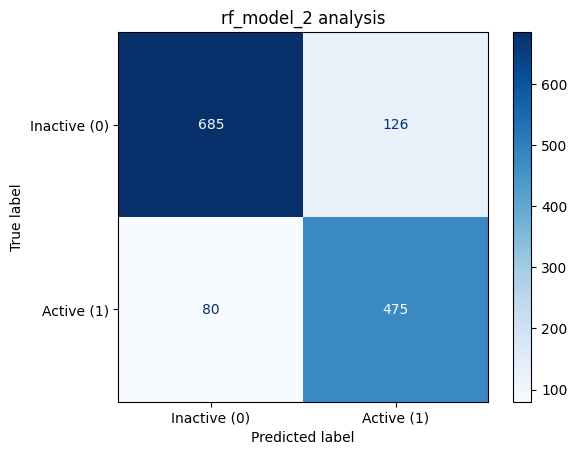

Confusion Matrix:
 [[685 126]
 [ 80 475]]


In [37]:
# let us analyse rf_model_2 and see how the model is performing
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

conf_matrix = confusion_matrix(y_test, rf_model_2.predict(X_test_scaled))

disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Inactive (0)', 'Active (1)'])
disp.plot(cmap='Blues', values_format='d')
plt.title("rf_model_2 analysis")
plt.show()

print("Confusion Matrix:\n", conf_matrix)


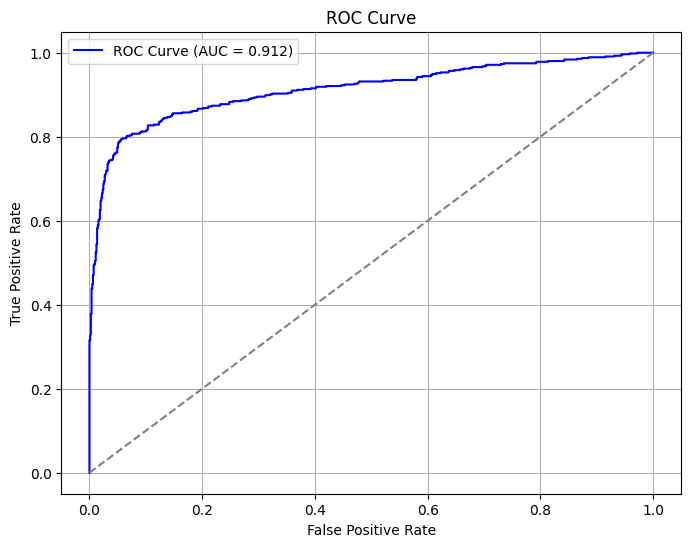

Optimal Threshold: 0.578

Classification Report (Adjusted Threshold):
              precision    recall  f1-score   support

           0       0.87      0.94      0.91       811
           1       0.91      0.79      0.85       555

    accuracy                           0.88      1366
   macro avg       0.89      0.87      0.88      1366
weighted avg       0.88      0.88      0.88      1366



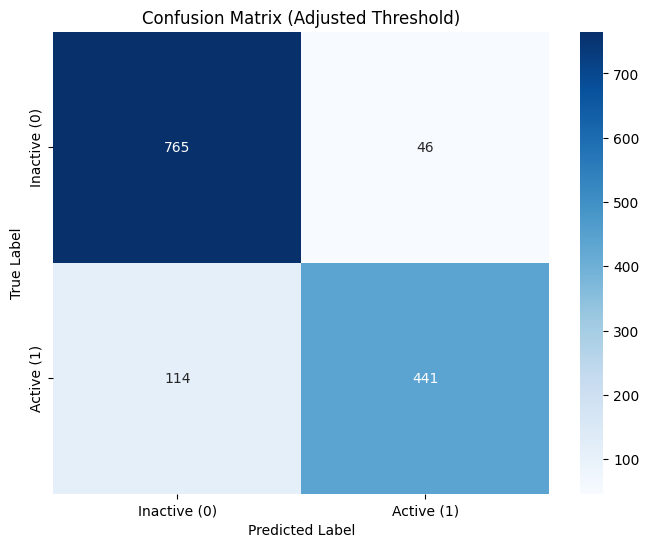

In [38]:
"""
Let us try to further improve rf_model_2 by adjusting the threashold for classifying compounds as active
The default is 0.5
"""

import numpy as np
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

y_pred_probs = rf_model_2.predict_proba(X_test_scaled)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_pred_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"ROC Curve (AUC = {roc_auc:.3f})", color="blue")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid()
plt.show()

# Select an optimal threshold
# we will use a threshold that maximizes sensitivity while minimizing false positives
optimal_idx = np.argmax(tpr - fpr)
optimal_threshold = thresholds[optimal_idx]
print(f"Optimal Threshold: {optimal_threshold:.3f}")

adjusted_y_pred = (y_pred_probs >= optimal_threshold).astype(int)

print("\nClassification Report (Adjusted Threshold):")
print(classification_report(y_test, adjusted_y_pred))

conf_matrix = confusion_matrix(y_test, adjusted_y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Inactive (0)", "Active (1)"], yticklabels=["Inactive (0)", "Active (1)"])
plt.title("Confusion Matrix (Adjusted Threshold)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
